In [58]:
import numpy as np
import pandas as pd
import re, nltk
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, recall_score, precision_score, \
                            f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import naive_bayes, svm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import string
import scipy.sparse.csr

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS

In [2]:
tweets = pd.read_csv('Tweets.csv')
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
tweets.shape

(14640, 15)

In [4]:
round(tweets['airline_sentiment'].value_counts(normalize=True) * 100, 2)

negative    62.69
neutral     21.17
positive    16.14
Name: airline_sentiment, dtype: float64

Пусть отрисовка графиков в этой задаче опциональна, все же сделаем это, чтобы иметь некоторое общее представление о данных

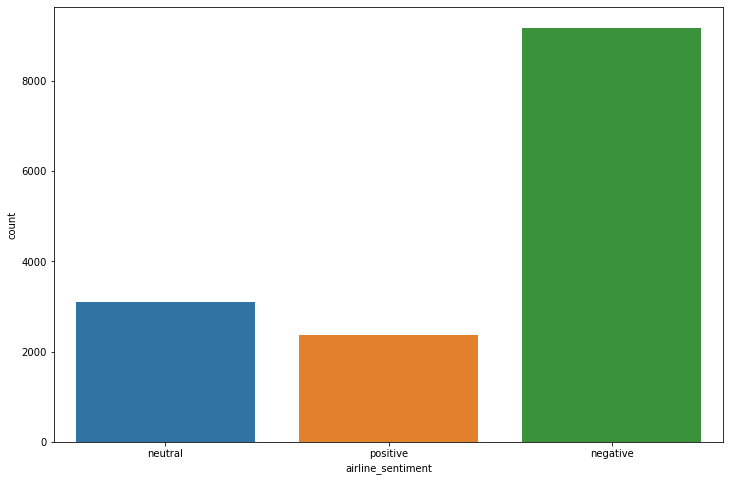

In [5]:
plt.figure(figsize=(12,8))
sns.countplot(tweets['airline_sentiment']);

In [6]:
tweetiest_regions = tweets.groupby('user_timezone').agg({'tweet_id':'count'}) \
                                    .sort_values(by='tweet_id', ascending=False).rename(columns={'tweet_id':'count'}).head(10)

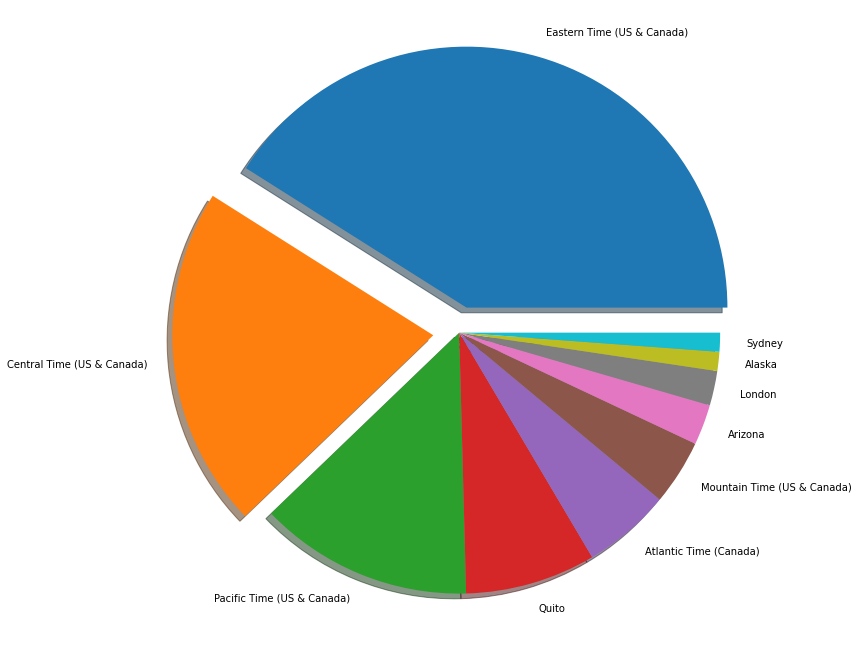

In [7]:
explodes = [0.1] * 2 + [0] * 8
plt.figure(figsize=(12,12))
plt.pie(tweetiest_regions['count'], labels=tweetiest_regions.index, explode=explodes, shadow=True);

### Определим функцию чистки и выводов по модели

In [8]:
def cleaning(tweet):
    reg = RegexpTokenizer('[a-zA-Z]\w+')
    tokens = reg.tokenize(tweet)
    all_tokens = [token.lower() for token in tokens]
    sentence = ' '.join(all_tokens[1:])
    return sentence

In [9]:
def total_scores(classifier, X_train, X_test, y_train, y_test, color = 'k'):
    
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    y_train_pred_proba = classifier.predict_proba(X_train)[:, 1]
    y_test_pred_proba = classifier.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_test_pred))
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
    plt.plot(precision, recall, color);
    plt.title('PR-curve')
    plt.xlabel('Precision');
    plt.ylabel('Recall');
    plt.show()

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_roc = roc_auc_score(y_train, y_train_pred_proba)
    test_roc = roc_auc_score(y_test, y_test_pred_proba)
    print(f'\nTrain accuracy: {train_acc}')
    print(f'Test accuracy: {test_acc}\n')
    print(f'Train roc-auc: {train_roc}')
    print(f'Test roc-auc: {test_roc}\n')
    
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    plt.plot(fpr, tpr, color);
    plt.title('ROC-AUC')
    plt.xlabel('False positive rate');
    plt.ylabel('True positive rate');
    plt.show()
    
    return test_acc, test_roc

### Предобработка текста

In [10]:
tweets = tweets.query('airline_sentiment != "neutral"')

In [11]:
tweets['cleaned_text'] = tweets['text'].apply(cleaning)

In [12]:
tweets['airline_sentiment'] = tweets['airline_sentiment'].map({'positive':1, 'negative':0})

In [13]:
tweets.reset_index(drop=True, inplace = True)

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

Рассмотрим наиболее часто встречаемые в положительных и отрицательных текстах слова: выдвигаем гипотезу, что именно эти слова будут значимыми в нашей задаче.

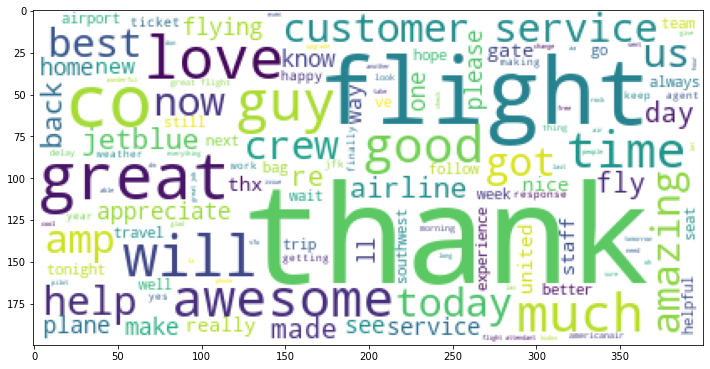

In [56]:
plt.figure(figsize=(12,10))

positive = tweets[tweets['airline_sentiment'] == 1]
positives_text = ' '.join(positive["cleaned_text"].values)

positive_wordcloud = WordCloud(background_color='white').generate(positives_text)
plt.imshow(positive_wordcloud)
plt.show()

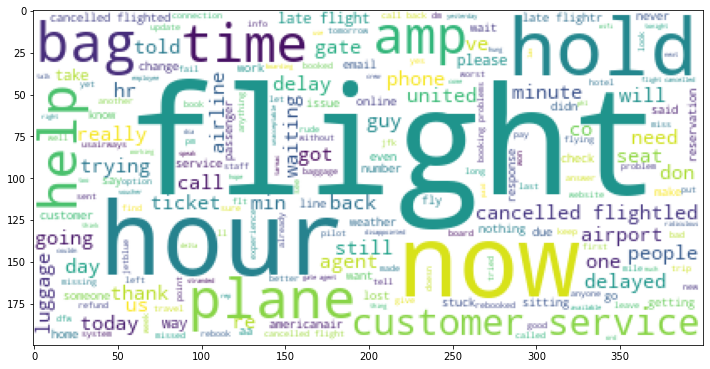

In [57]:
plt.figure(figsize=(12,10))

negative = tweets[tweets['airline_sentiment'] == 0]
negatives_text = ' '.join(negative["cleaned_text"].values)

negative_wordcloud = WordCloud(background_color='white').generate(negatives_text)
plt.imshow(negative_wordcloud)
plt.show()

Для работы со словами используем **TF-IDF** без n-грамм: *их добавление приводит только к лишним нагрузкам и слабо влияет на итоговое качество модели*

In [15]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,1))
X = vectorizer.fit_transform(tweets['cleaned_text'])
y = tweets['airline_sentiment']

In [16]:
pd.Series(vectorizer.vocabulary_).shape

(11290,)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=25)

## Линейные методы и байесовские классификаторы
Здесь рассмотрим логистическую регрессию и метод опорных векторов, которые должны отлично работать с разреженными признаками в большом количестве

**Логистическая регрессия**

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2295
           1       0.89      0.70      0.78       591

    accuracy                           0.92      2886
   macro avg       0.91      0.84      0.87      2886
weighted avg       0.92      0.92      0.92      2886



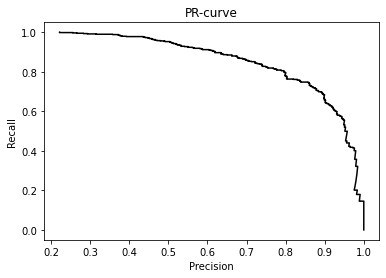


Train accuracy: 0.9876372039283651
Test accuracy: 0.920997920997921

Train roc-auc: 0.99880783092049
Test roc-auc: 0.9541215546192156



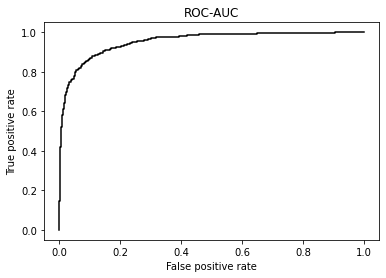

In [18]:
lr = LogisticRegression(C = 10)
lr_acc, lr_roc = total_scores(lr, X_train, X_test, y_train, y_test)

**SVC**

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2295
           1       0.91      0.65      0.76       591

    accuracy                           0.92      2886
   macro avg       0.91      0.82      0.86      2886
weighted avg       0.92      0.92      0.91      2886



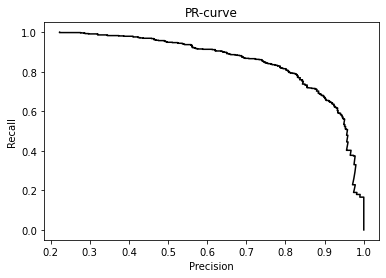


Train accuracy: 0.9993067590987869
Test accuracy: 0.9161469161469161

Train roc-auc: 0.9996461740887435
Test roc-auc: 0.9557188620889229



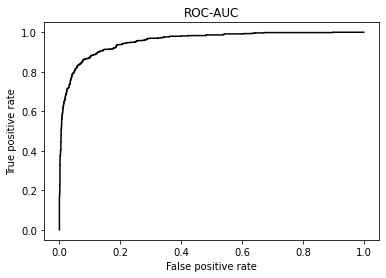

In [19]:
svc = svm.SVC(C = 10, kernel = 'rbf', probability=True)
svc_acc, svc_roc = total_scores(svc, X_train, X_test, y_train, y_test)

**SGD**

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2295
           1       0.93      0.56      0.70       591

    accuracy                           0.90      2886
   macro avg       0.91      0.77      0.82      2886
weighted avg       0.90      0.90      0.89      2886



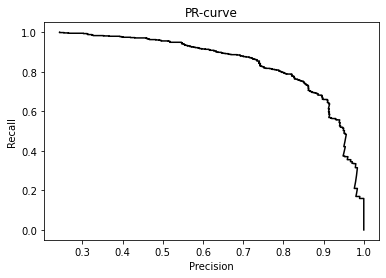


Train accuracy: 0.9217793183131138
Test accuracy: 0.9012474012474012

Train roc-auc: 0.9851795276024385
Test roc-auc: 0.9549959634163874



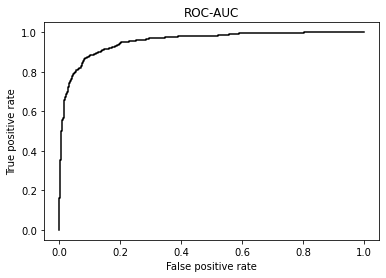

In [20]:
sgd = SGDClassifier(loss='log')
sgd_acc, sgd_roc = total_scores(sgd, X_train, X_test, y_train, y_test)

**Наивные байесовские классификаторы**

Здесь используем 3 наивных байесовских классификатора: бернулли, мультиномиальный и гауссовский.

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2295
           1       0.80      0.48      0.60       591

    accuracy                           0.87      2886
   macro avg       0.84      0.72      0.76      2886
weighted avg       0.86      0.87      0.85      2886



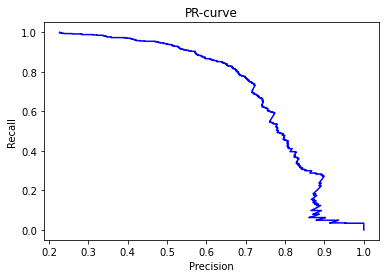


Train accuracy: 0.9104563835932987
Test accuracy: 0.8683298683298684

Train roc-auc: 0.9743065651657877
Test roc-auc: 0.9272508100815058



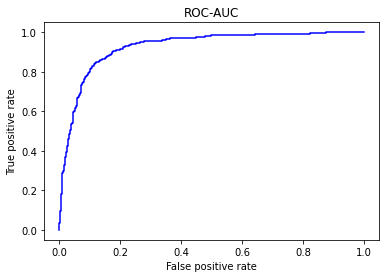

In [21]:
bernoulli_nb = naive_bayes.BernoulliNB()
bernoulli_acc, bernoulli_roc = total_scores(bernoulli_nb, X_train, X_test, y_train, y_test, 'b')

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2295
           1       0.97      0.25      0.40       591

    accuracy                           0.84      2886
   macro avg       0.91      0.62      0.65      2886
weighted avg       0.87      0.84      0.81      2886



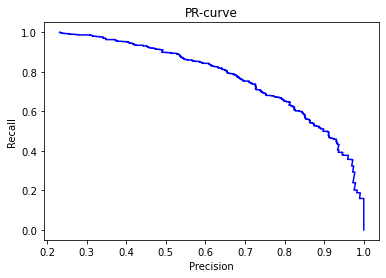


Train accuracy: 0.8649335644136338
Test accuracy: 0.8447678447678447

Train roc-auc: 0.9678026619711798
Test roc-auc: 0.9258234446250769



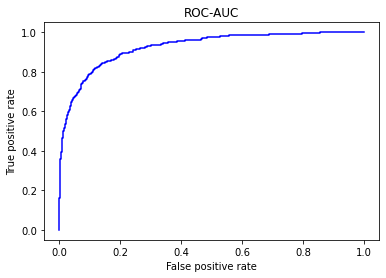

In [22]:
multinomial_nb = naive_bayes.MultinomialNB()
multinomial_acc, multinomial_roc = total_scores(multinomial_nb, X_train, X_test, y_train, y_test, 'b')

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      2295
           1       0.37      0.68      0.48       591

    accuracy                           0.70      2886
   macro avg       0.63      0.69      0.64      2886
weighted avg       0.79      0.70      0.73      2886



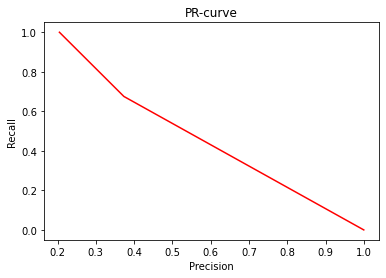


Train accuracy: 0.8601964182553438
Test accuracy: 0.7013167013167013

Train roc-auc: 0.9121022809821299
Test roc-auc: 0.6915939528659744



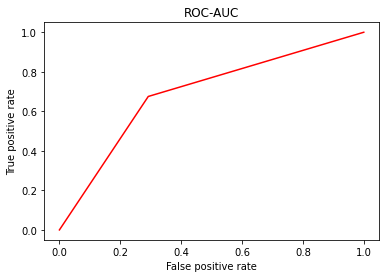

In [23]:
gaussian_nb = naive_bayes.GaussianNB()
gaussian_acc, gaussian_roc = total_scores(gaussian_nb, X_train.toarray(), X_test.toarray(), y_train, y_test, 'r')

## "Деревянные" методы

### Случаный лес
Рассмотрим 2 случайных леса: первый будет обучен на всех признаках, а второй - на подвыборке признаков, полученных с помощью анализа главных компонент

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2295
           1       0.86      0.58      0.70       591

    accuracy                           0.90      2886
   macro avg       0.88      0.78      0.82      2886
weighted avg       0.89      0.90      0.89      2886



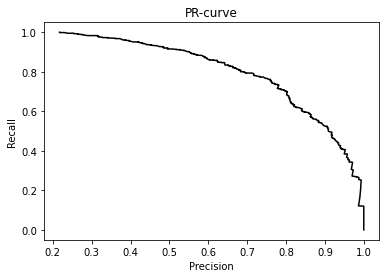


Train accuracy: 0.9993067590987869
Test accuracy: 0.8957033957033957

Train roc-auc: 0.999990284238099
Test roc-auc: 0.932892442557019



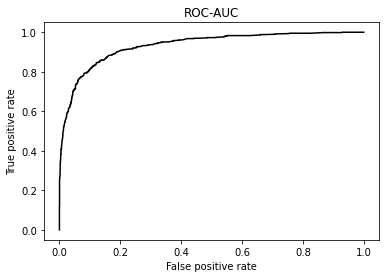

Wall time: 29.7 s


In [24]:
%%time
rf = RandomForestClassifier(n_estimators=200)
rf_acc, rf_roc = total_scores(rf, X_train, X_test, y_train, y_test)

Теперь применим PCA с 90% объясненной дисперсии

In [25]:
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())
X_train_pca = scipy.sparse.csr_matrix(X_train_pca)
X_test_pca = scipy.sparse.csr_matrix(X_test_pca)

In [26]:
X_train_pca.shape

(8655, 2955)

Количество признаков сократилось с 11290 до 2955, что довольно существенно, но не очень ожидаемо для задачи классификации (я был уверен в том, что уменьшение признаков будет намного более резким)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2295
           1       0.98      0.19      0.32       591

    accuracy                           0.83      2886
   macro avg       0.91      0.60      0.61      2886
weighted avg       0.86      0.83      0.79      2886



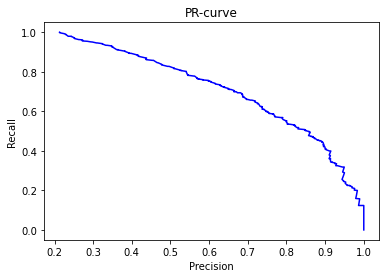


Train accuracy: 0.9987290583477758
Test accuracy: 0.834026334026334

Train roc-auc: 0.9999940557574867
Test roc-auc: 0.8863769911047706



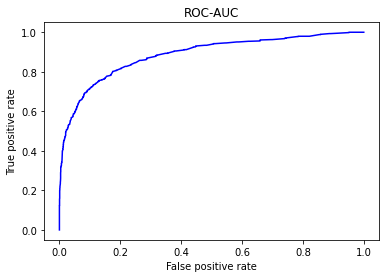

Wall time: 2min 11s


In [63]:
%%time
rf_pca = RandomForestClassifier(n_estimators=200)
rf_pca_acc, rf_pca_roc = total_scores(rf_pca, X_train_pca.toarray(), X_test_pca.toarray(), y_train, y_test, 'b')

Как видно, качество заметно ухудшилось, но время, затраченное на обучение, заметно увеличилось (скорее всего, это произошло из-за проделанного вручную PCA и сжатия обучающей матрицы).

### XGBoost

[22:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2295
           1       0.86      0.63      0.73       591

    accuracy                           0.90      2886
   macro avg       0.88      0.80      0.84      2886
weighted avg       0.90      0.90      0.90      2886



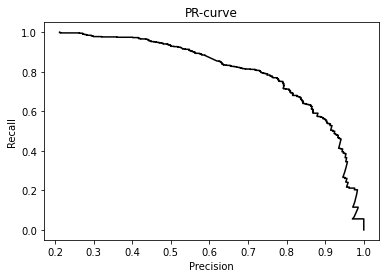


Train accuracy: 0.9460427498555748
Test accuracy: 0.9033264033264033

Train roc-auc: 0.9865769575251486
Test roc-auc: 0.9390236259948611



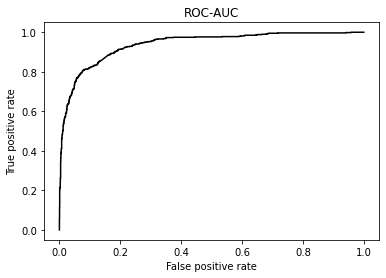

In [28]:
xgb = XGBClassifier(learning_rate = 0.10, n_estimators = 500)
xgb_acc, xgb_roc = total_scores(xgb, X_train, X_test, y_train, y_test)

### Итоги

In [64]:
scores = {'Logistic regression':[lr_acc, lr_roc],
          'SVM':[svc_acc, svc_roc],
          'SGD':[sgd_acc, sgd_roc],
          'Bernoulli NB':[bernoulli_acc, bernoulli_roc],
          'Multinomial NB':[multinomial_acc, multinomial_roc],
          'Gaussian NB':[gaussian_acc, gaussian_roc],
          'Random forest':[rf_acc, rf_roc],
          'Random forest (PCA)':[rf_pca_acc, rf_pca_roc],
          'XGBoost':[xgb_acc, xgb_roc]}

In [83]:
df_scores = pd.DataFrame.from_dict(data=scores).T.rename(columns={0:'Accuracy', 1:'ROC-AUC'}) \
                        .sort_values(['ROC-AUC'], ascending=False)
df_scores

,Accuracy,ROC-AUC
SVM,0.916147,0.955719
SGD,0.901247,0.954996
Logistic regression,0.920998,0.954122
XGBoost,0.903326,0.939024
Random forest,0.895703,0.932892
Bernoulli NB,0.868330,0.927251
Multinomial NB,0.844768,0.925823
Random forest (PCA),0.834026,0.886377
Gaussian NB,0.701317,0.691594


Как видно, лучше всего справились линейные модели (как и было предположено), затем идут XGB и Random forest, в большинстве задач отличающиеся хорошим качеством, затем наивные байесовские классификаторы. В целом, не считая Gaussian NB, классификаторы показали хорошее качество.